# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                                   
Sample_102  P14621;U3KPX8;U3KQL2                                                                15.721
Sample_134  B1AMW1;H0YDI1;P19256;P19256-2;P19256-3                                              15.021
Sample_082  Q9NTU7                                                                              16.201
Sample_190  P08493;P08493-2                                                                     18.899
Sample_004  Q8NI17;Q8NI17-10;Q8NI17-11;Q8NI17-12;Q8NI17-2;Q8NI17-3;Q8NI17-5;Q8NI17-6;Q8NI17-9   26.982
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                 
Sample_121  P48147                            12.780
Sample_056  P31151                            15.830
Sample_034  A0A0C4DGV4;E9PLX3;O43504;R4GMU8   13.439
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.395
            A0A075B6Q5                 12.039
            A0A075B6R2                 12.819
            A0A075B6S5                 12.305
            A0A087WSY4                 13.099
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.360
            Q9UI40;Q9UI40-2            12.839
            Q9UIW2                     12.347
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   10.950
            Q9UP79                     12.079
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.166,15.050,16.842,19.863,15.887,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,17.153,19.067,...,15.528,15.576,14.126,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.780,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.272,17.705,17.039,16.071,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.245,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.510,15.345,17.084,18.708,14.249,19.433,11.479,11.017
Sample_207,15.739,16.877,15.469,16.898,15.019,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.221,12.154,12.643,14.033,12.833,13.357,13.336,13.054,13.091,14.369
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.683,19.067,16.127,...,13.199,13.003,13.165,12.703,12.312,13.917,13.042,13.357,13.557,12.270
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.379,14.699,12.261,12.649,12.951,13.223,12.482,13.674,12.775,12.902
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.853,12.411,13.349,12.980,12.609,14.077,13.382,14.147,12.345,13.213
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.131,12.562,13.925,14.051,13.735,13.292,13.593,11.697,12.362,13.072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.323,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 373.62it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.48it/s]

100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.68it/s]

100%|██████████| 3/3 [00:00<00:00,  6.76it/s]

100%|██████████| 3/3 [00:00<00:00,  7.04it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.34it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.56it/s]

100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.61it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.68it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.34it/s]

100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.28it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.67it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.57it/s]

100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.85it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.15it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.95it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.49it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.35it/s]

100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.88it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.43it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.32it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.77it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.48it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.36it/s]

100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

100%|██████████| 8/8 [00:02<00:00,  3.74it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 10.28it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.32it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.71it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.43it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.93it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.47it/s]

100%|██████████| 9/9 [00:02<00:00,  3.33it/s]

100%|██████████| 9/9 [00:02<00:00,  4.12it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.35it/s]

 30%|███       | 3/10 [00:00<00:01,  6.81it/s]

 40%|████      | 4/10 [00:00<00:00,  6.64it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.39it/s]

 60%|██████    | 6/10 [00:00<00:00,  5.88it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.48it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.99it/s]

 90%|█████████ | 9/10 [00:01<00:00,  3.57it/s]

100%|██████████| 10/10 [00:02<00:00,  3.31it/s]

100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.33it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.80it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.07it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.64it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.28it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.44it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.39it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.78it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.35it/s]

100%|██████████| 11/11 [00:02<00:00,  3.16it/s]

100%|██████████| 11/11 [00:02<00:00,  4.21it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.54it/s]

 33%|███▎      | 4/12 [00:00<00:01,  6.80it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.02it/s]

 50%|█████     | 6/12 [00:00<00:01,  5.74it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.31it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.20it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.08it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.31it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.90it/s]

100%|██████████| 12/12 [00:02<00:00,  3.54it/s]

100%|██████████| 12/12 [00:02<00:00,  4.67it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 13.40it/s]

 31%|███       | 4/13 [00:00<00:01,  6.68it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.97it/s]

 46%|████▌     | 6/13 [00:00<00:01,  5.51it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.19it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.88it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.51it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.47it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.29it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.47it/s]

100%|██████████| 13/13 [00:02<00:00,  3.16it/s]

100%|██████████| 13/13 [00:02<00:00,  4.36it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.82it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.18it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.12it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.89it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.68it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.76it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.86it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.83it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  4.75it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.91it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.75it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.71it/s]

100%|██████████| 14/14 [00:02<00:00,  4.85it/s]

100%|██████████| 14/14 [00:02<00:00,  4.96it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.92it/s]

 20%|██        | 3/15 [00:00<00:02,  5.60it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.03it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.85it/s]

 40%|████      | 6/15 [00:01<00:01,  4.60it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.25it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.09it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.35it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.17it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.38it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.48it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.95it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.11it/s]

100%|██████████| 15/15 [00:03<00:00,  5.21it/s]

100%|██████████| 15/15 [00:03<00:00,  4.80it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.041 0.016          0.857 0.238       0.157   
2             0.003 0.000      0.038 0.010          0.706 0.090       0.617   
3             0.003 0.000      0.035 0.002          0.761 0.088       0.649   
4             0.003 0.000      0.037 0.005          0.742 0.085       0.648   
5             0.003 0.000      0.034 0.003          0.715 0.083       0.693   
6             0.004 0.003      0.039 0.011          0.723 0.089       0.698   
7             0.003 0.002      0.030 0.008          0.794 0.071       0.774   
8             0.004 0.004      0.044 0.016          0.800 0.074       0.774   
9             0.003 0.001      0.038 0.016          0.816 0.083       0.833   
10            0.003 0.001      0.036 0.012          0.807 0.082       0.834   
11            0.004 0.002      0.039 0.015          0.807 0.087       0.828   
12            0.004 0.003      0.045 0.016          0.825 0.081       0.819   
13            0.005 0.004      0.045 0.019          0.821 0.085       0.815   
14            0.004 0.002      0.042 0.018          0.817 0.084       0.811   
15            0.004 0.003      0.040 0.022          0.812 0.086       0.808   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.089   0.257 0.127                  0.570 0.043        0.865   
2          0.109   0.652 0.080                  0.712 0.059        0.792   
3          0.114   0.695 0.085                  0.749 0.062        0.821   
4          0.116   0.685 0.081                  0.740 0.059        0.814   
5          0.109   0.698 0.073                  0.744 0.057        0.823   
6          0.118   0.704 0.082                  0.749 0.064        0.823   
7          0.097   0.780 0.066                  0.812 0.053        0.870   
8          0.097   0.782 0.068                  0.815 0.054        0.868   
9          0.097   0.820 0.067                  0.846 0.058        0.918   
10         0.100   0.816 0.069                  0.843 0.060        0.915   
11         0.101   0.813 0.071                  0.840 0.061        0.915   
12         0.093   0.818 0.068                  0.845 0.057        0.921   
13         0.096   0.814 0.068                  0.841 0.057        0.919   
14         0.095   0.809 0.067                  0.837 0.056        0.918   
15         0.091   0.806 0.067                  0.834 0.057        0.914   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.832 0.085        210.000 0.000  
2          0.064                  0.763 0.083        210.000 0.000  
3          0.059                  0.790 0.081        210.000 0.000  
4          0.059                  0.782 0.078        210.000 0.000  
5          0.058                  0.785 0.081        210.000 0.000  
6          0.058                  0.784 0.081        210.000 0.000  
7          0.055                  0.844 0.076        210.000 0.000  
8          0.055                  0.845 0.075        210.000 0.000  
9          0.046                  0.907 0.050        210.000 0.000  
10         0.048                  0.904 0.051        210.000 0.000  
11         0.048                  0.903 0.052        210.000 0.000  
12         0.047                  0.912 0.050        210.000 0.000  
13         0.049                  0.910 0.051        210.000 0.000  
14         0.049                  0.909 0.050        210.000 0.000  
15         0.050                  0.906 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 132.96it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.33it/s]

100%|██████████| 2/2 [00:00<00:00, 11.28it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 12.64it/s]

100%|██████████| 3/3 [00:00<00:00,  9.34it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.41it/s]

100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

100%|██████████| 4/4 [00:00<00:00,  7.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.51it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.45it/s]

100%|██████████| 5/5 [00:00<00:00,  6.93it/s]

100%|██████████| 5/5 [00:00<00:00,  7.38it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 10.68it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  6.29it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.84it/s]

100%|██████████| 6/6 [00:00<00:00,  5.92it/s]

100%|██████████| 6/6 [00:00<00:00,  6.24it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 12.55it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.59it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  7.15it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.85it/s]

100%|██████████| 7/7 [00:00<00:00,  6.69it/s]

100%|██████████| 7/7 [00:00<00:00,  7.19it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.85it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.50it/s]

 50%|█████     | 4/8 [00:00<00:00,  6.17it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  5.83it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  5.89it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.93it/s]

100%|██████████| 8/8 [00:01<00:00,  5.91it/s]

100%|██████████| 8/8 [00:01<00:00,  6.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 11.92it/s]

 44%|████▍     | 4/9 [00:00<00:00,  7.70it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  7.24it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  6.84it/s]

 78%|███████▊  | 7/9 [00:00<00:00,  6.67it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.50it/s]

100%|██████████| 9/9 [00:01<00:00,  5.55it/s]

100%|██████████| 9/9 [00:01<00:00,  6.39it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.07it/s]

 40%|████      | 4/10 [00:00<00:00,  7.40it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.98it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.75it/s]

 70%|███████   | 7/10 [00:00<00:00,  6.63it/s]

 80%|████████  | 8/10 [00:01<00:00,  6.39it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.38it/s]

100%|██████████| 10/10 [00:01<00:00,  6.20it/s]

100%|██████████| 10/10 [00:01<00:00,  6.67it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.62it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.58it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.95it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.49it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.45it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.46it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.64it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.75it/s]

100%|██████████| 11/11 [00:01<00:00,  5.91it/s]

100%|██████████| 11/11 [00:01<00:00,  6.03it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.87it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.77it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.76it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.11it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.91it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.59it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.64it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.69it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.61it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.59it/s]

100%|██████████| 12/12 [00:02<00:00,  4.62it/s]

100%|██████████| 12/12 [00:02<00:00,  4.95it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.42it/s]

 31%|███       | 4/13 [00:00<00:01,  6.20it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.59it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.39it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.18it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.15it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.39it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.80it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.94it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  6.28it/s]

100%|██████████| 13/13 [00:02<00:00,  6.28it/s]

100%|██████████| 13/13 [00:02<00:00,  5.91it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.12it/s]

 29%|██▊       | 4/14 [00:00<00:01,  8.28it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.58it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.14it/s]

 50%|█████     | 7/14 [00:00<00:01,  6.79it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.41it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.88it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.34it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.68it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.76it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  7.91it/s]

100%|██████████| 14/14 [00:01<00:00,  8.03it/s]

100%|██████████| 14/14 [00:01<00:00,  7.62it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.31it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.10it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.45it/s]

 40%|████      | 6/15 [00:00<00:01,  7.06it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.30it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.27it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.29it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.29it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.06it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.24it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.38it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  6.48it/s]

100%|██████████| 15/15 [00:02<00:00,  6.59it/s]

100%|██████████| 15/15 [00:02<00:00,  6.71it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.026 0.010          0.010 0.071       0.001   
2             0.002 0.000      0.022 0.005          0.693 0.116       0.523   
3             0.002 0.000      0.022 0.005          0.750 0.112       0.626   
4             0.002 0.001      0.023 0.010          0.772 0.104       0.607   
5             0.002 0.001      0.023 0.005          0.757 0.087       0.635   
6             0.002 0.000      0.021 0.003          0.792 0.087       0.688   
7             0.002 0.001      0.022 0.005          0.758 0.098       0.728   
8             0.002 0.001      0.023 0.005          0.764 0.104       0.734   
9             0.002 0.000      0.022 0.004          0.762 0.104       0.736   
10            0.002 0.001      0.024 0.006          0.769 0.103       0.734   
11            0.002 0.000      0.020 0.001          0.796 0.090       0.784   
12            0.003 0.001      0.031 0.010          0.792 0.091       0.769   
13            0.002 0.000      0.021 0.004          0.786 0.094       0.767   
14            0.002 0.000      0.019 0.000          0.787 0.092       0.760   
15            0.002 0.000      0.020 0.000          0.796 0.096       0.769   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.861   
2          0.134   0.586 0.108                  0.674 0.075        0.740   
3          0.126   0.673 0.098                  0.733 0.068        0.789   
4          0.120   0.672 0.095                  0.736 0.063        0.804   
5          0.125   0.683 0.093                  0.742 0.062        0.807   
6          0.123   0.730 0.088                  0.777 0.065        0.823   
7          0.115   0.736 0.084                  0.776 0.067        0.871   
8          0.117   0.742 0.088                  0.781 0.070        0.869   
9          0.121   0.742 0.088                  0.781 0.071        0.868   
10         0.114   0.745 0.084                  0.783 0.069        0.870   
11         0.105   0.784 0.073                  0.816 0.061        0.898   
12         0.099   0.774 0.065                  0.808 0.055        0.907   
13         0.096   0.771 0.072                  0.804 0.061        0.909   
14         0.099   0.768 0.073                  0.803 0.061        0.908   
15         0.105   0.776 0.076                  0.810 0.063        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.829 0.087        210.000 0.000  
2          0.077                  0.672 0.097        210.000 0.000  
3          0.073                  0.758 0.090        210.000 0.000  
4          0.071                  0.778 0.086        210.000 0.000  
5          0.068                  0.783 0.084        210.000 0.000  
6          0.073                  0.796 0.088        210.000 0.000  
7          0.062                  0.840 0.076        210.000 0.000  
8          0.061                  0.838 0.075        210.000 0.000  
9          0.061                  0.836 0.076        210.000 0.000  
10         0.059                  0.836 0.072        210.000 0.000  
11         0.049                  0.866 0.062        210.000 0.000  
12         0.047                  0.885 0.053        210.000 0.000  
13         0.046                  0.890 0.051        210.000 0.000  
14         0.047                  0.889 0.051        210.000 0.000  
15         0.047                  0.887 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1463.47it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 66.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 45.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.29it/s]

100%|██████████| 5/5 [00:00<00:00, 43.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 42.92it/s]

100%|██████████| 6/6 [00:00<00:00, 41.03it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.17it/s]

100%|██████████| 7/7 [00:00<00:00, 40.22it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.50it/s]

100%|██████████| 8/8 [00:00<00:00, 39.63it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 43.47it/s]

100%|██████████| 9/9 [00:00<00:00, 39.06it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 43.25it/s]

100%|██████████| 10/10 [00:00<00:00, 37.80it/s]

100%|██████████| 10/10 [00:00<00:00, 38.43it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 43.26it/s]

 91%|█████████ | 10/11 [00:00<00:00, 37.79it/s]

100%|██████████| 11/11 [00:00<00:00, 37.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.20it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 37.83it/s]

100%|██████████| 12/12 [00:00<00:00, 37.74it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.36it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 37.77it/s]

100%|██████████| 13/13 [00:00<00:00, 37.51it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.33it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 37.67it/s]

100%|██████████| 14/14 [00:00<00:00, 36.39it/s]

100%|██████████| 14/14 [00:00<00:00, 37.19it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.21it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 37.67it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 36.38it/s]

100%|██████████| 15/15 [00:00<00:00, 36.98it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.554 0.171       0.204   
3             0.002 0.000      0.019 0.000          0.519 0.113       0.305   
4             0.002 0.000      0.019 0.000          0.660 0.109       0.533   
5             0.002 0.000      0.019 0.000          0.648 0.103       0.543   
6             0.002 0.000      0.019 0.000          0.644 0.097       0.539   
7             0.002 0.000      0.019 0.000          0.672 0.074       0.604   
8             0.002 0.000      0.019 0.000          0.678 0.085       0.597   
9             0.002 0.000      0.019 0.000          0.675 0.088       0.595   
10            0.002 0.000      0.019 0.000          0.669 0.082       0.588   
11            0.002 0.000      0.019 0.000          0.660 0.085       0.579   
12            0.002 0.000      0.019 0.000          0.651 0.088       0.588   
13            0.002 0.000      0.020 0.000          0.649 0.087       0.589   
14            0.002 0.000      0.020 0.000          0.648 0.090       0.584   
15            0.002 0.000      0.019 0.000          0.643 0.086       0.573   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.745   
2          0.081   0.290 0.099                  0.539 0.050        0.622   
3          0.103   0.379 0.104                  0.552 0.058        0.623   
4          0.115   0.584 0.098                  0.665 0.066        0.741   
5          0.102   0.585 0.085                  0.662 0.063        0.767   
6          0.119   0.580 0.094                  0.660 0.066        0.781   
7          0.110   0.631 0.081                  0.694 0.059        0.790   
8          0.109   0.629 0.078                  0.693 0.059        0.792   
9          0.106   0.627 0.081                  0.691 0.063        0.789   
10         0.114   0.619 0.080                  0.686 0.060        0.784   
11         0.104   0.610 0.075                  0.678 0.059        0.777   
12         0.107   0.611 0.078                  0.676 0.062        0.772   
13         0.109   0.612 0.079                  0.676 0.062        0.769   
14         0.105   0.608 0.079                  0.674 0.063        0.766   
15         0.097   0.600 0.070                  0.667 0.057        0.762   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.688 0.085        210.000 0.000  
2          0.072                  0.549 0.076        210.000 0.000  
3          0.060                  0.557 0.069        210.000 0.000  
4          0.072                  0.688 0.087        210.000 0.000  
5          0.069                  0.720 0.082        210.000 0.000  
6          0.063                  0.723 0.084        210.000 0.000  
7          0.059                  0.737 0.073        210.000 0.000  
8          0.058                  0.736 0.080        210.000 0.000  
9          0.060                  0.731 0.080        210.000 0.000  
10         0.059                  0.728 0.081        210.000 0.000  
11         0.061                  0.723 0.082        210.000 0.000  
12         0.062                  0.717 0.082        210.000 0.000  
13         0.061                  0.715 0.081        210.000 0.000  
14         0.061                  0.712 0.082        210.000 0.000  
15         0.061                  0.706 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,12,15
score_time,13,12,14
test_precision,1,11,8
test_recall,10,11,7
test_f1,9,11,7
test_balanced_accuracy,9,11,7
test_roc_auc,12,13,8
test_average_precision,12,13,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.71it/s]

 31%|███       | 4/13 [00:00<00:00, 10.27it/s]

 46%|████▌     | 6/13 [00:00<00:00,  9.23it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  8.90it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  8.65it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  8.64it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.45it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.33it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.42it/s]

100%|██████████| 13/13 [00:01<00:00,  8.48it/s]

100%|██████████| 13/13 [00:01<00:00,  8.91it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 43.07it/s]

100%|██████████| 8/8 [00:00<00:00, 39.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.72it/s]

 33%|███▎      | 4/12 [00:00<00:00, 12.35it/s]

 50%|█████     | 6/12 [00:00<00:00, 10.93it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.45it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 10.15it/s]

100%|██████████| 12/12 [00:01<00:00,  9.91it/s]

100%|██████████| 12/12 [00:01<00:00, 10.56it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


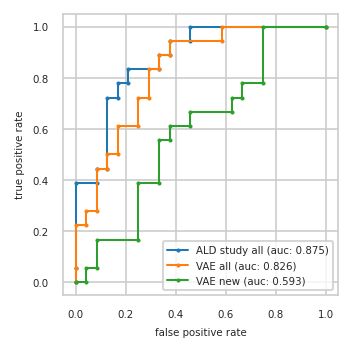

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.389   0.000 0.222   0.042 0.056
3          0.083 0.389   0.042 0.222   0.083 0.056
4          0.083 0.444   0.042 0.278   0.083 0.167
5          0.125 0.444   0.083 0.278   0.250 0.167
6          0.125 0.722   0.083 0.444   0.250 0.389
7          0.167 0.722   0.125 0.444   0.333 0.389
8          0.167 0.778   0.125 0.500   0.333 0.556
9          0.208 0.778   0.167 0.500   0.375 0.556
10         0.208 0.833   0.167 0.611   0.375 0.611
11         0.333 0.833   0.250 0.611   0.458 0.611
12         0.333 0.889   0.250 0.722   0.458 0.667
13         0.375 0.889   0.292 0.722   0.625 0.667
14         0.375 0.944   0.292 0.833   0.625 0.722
15         0.458 0.944   0.333 0.833   0.667 0.722
16         0.458 1.000   0.333 0.889   0.667 0.778
17         1.000 1.000   0.375 0.889   0.750 0.778
18           NaN   NaN   0.375 0.944   0.750 1.000
19           NaN   NaN   0.583 0.944   1.000 1.000
20           NaN   NaN   0.583 1.000     NaN   NaN
21           NaN   NaN   1.000 1.000     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A075B6J9,A0A087WXB8;Q9Y274,P16519;P16519-3
2,Q01995,P02741,P30048;P30048-2
3,Q9Y2T3;Q9Y2T3-3,P04075,P31321
4,P61981,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P18428,F8WE04;P04792,E9PK25;G3V1A4;P23528
6,P04075,P61981,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
7,P14174,P14174,Q96GD0
8,P08294,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


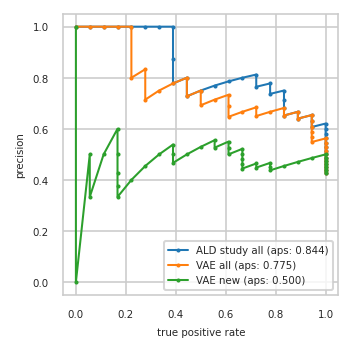

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.438 0.778
11         0.581 1.000     0.548 0.944     0.452 0.778
12         0.600 1.000     0.567 0.944     0.467 0.778
13         0.621 1.000     0.586 0.944     0.448 0.722
14         0.607 0.944     0.607 0.944     0.464 0.722
15         0.630 0.944     0.630 0.944     0.444 0.667
16         0.654 0.944     0.654 0.944     0.462 0.667
17         0.640 0.889     0.640 0.889     0.480 0.667
18         0.667 0.889     0.667 0.889     0.500 0.667
19         0.652 0.833     0.652 0.833     0.522 0.667
20         0.682 0.833     0.682 0.833     0.500 0.611
21         0.714 0.833     0.667 0.778     0.524 0.611
22         0.750 0.833     0.650 0.722     0.550 0.611
23         0.737 0.778     0.684 0.722     0.526 0.556
24         0.778 0.778     0.667 0.667     0.556 0.556
25         0.765 0.722     0.647 0.611     0.529 0.500
26         0.812 0.722     0.688 0.611     0.500 0.444
27         0.800 0.667     0.733 0.611     0.467 0.389
28         0.786 0.611     0.714 0.556     0.500 0.389
29         0.769 0.556     0.692 0.500     0.538 0.389
30         0.750 0.500     0.750 0.500     0.500 0.333
31         0.727 0.444     0.727 0.444     0.455 0.278
32         0.800 0.444     0.800 0.444     0.400 0.222
33         0.778 0.389     0.778 0.389     0.333 0.167
34         0.875 0.389     0.750 0.333     0.375 0.167
35         1.000 0.389     0.714 0.278     0.429 0.167
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


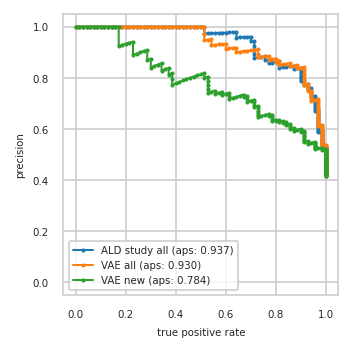

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


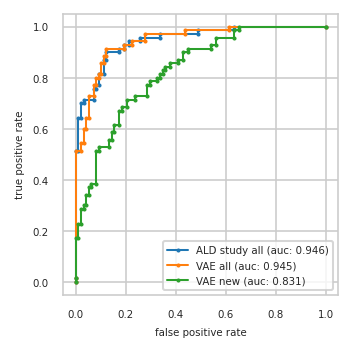

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}